In [1]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt
!pip install wandb -q
!pip install opencv-python -q

In [5]:
# Restart the runtime by ending the process
exit()

In [1]:
import os
import matplotlib.pyplot as plt


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS, MAP_NAN, NORMALIZE, LABELS_PATH, HEADER_PATH, SELECTED_BANDS
from serving.common import list_blobs_with_prefix
from serving.hist_training import create_data_sample, get_labels, LstmModel, TimeDependentDenseLstmModel, pen_low_lenient_high_loss #, load_dataset_from_gcp, save_dataset_to_gcp, create_hist_dataset
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels, check_blob_exists
import logging
import io
import itertools
import time

from keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import wandb
from google.cloud import secretmanager

tf.config.run_functions_eagerly(True)

In [2]:
# SETUP

# Create the Secret Manager client
client = secretmanager.SecretManagerServiceClient()

# Define the secret name and version
secret_name = "projects/1038596154733/secrets/wandb/versions/1"

# Access the secret
response = client.access_secret_version(name=secret_name)
secret_value = response.payload.data.decode('UTF-8')

#####
CREATE_DATASET = False
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
months = MONTHS
map_nan = MAP_NAN
normalize = NORMALIZE
num_bins = NUM_BINS
client = storage.Client()
bucket = client.get_bucket(bucket_name)


batch_size = 20
img_range =  {"count_start":0,
              "no_records":1000,
             "ascending": False}

In [3]:

def save_dataset_to_gcp(
    dataset, labels, bucket_name="vgnn", directory="dataset"
):
    # Initialize GCP client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    buffer = io.BytesIO()
    np.save(buffer, labels)
    buffer.seek(0)
    
    destination_blob_name = f"{directory}/labels.npy"
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_file(buffer, content_type="application/octet-stream")
    print("Labels uploaded to GCS successfully!")
    
    buffer = io.BytesIO()
    np.save(buffer, dataset)
    buffer.seek(0)
    
    destination_blob_name = f"{directory}/dataset.npy"
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_file(buffer, content_type="application/octet-stream")
    print("Dataset uploaded to GCS successfully!")    

    print(f"Dataset saved to gs://{bucket_name}/{directory}")    
    
def load_dataset_from_gcp(bucket_name="vgnn", directory="dataset"
):
    # Initialize GCP client
    client = storage.Client()
    bucket = client.bucket(bucket_name)    
    blob_name = f"{directory}/labels.npy"
    blob = bucket.blob(blob_name)
    
    buffer = io.BytesIO()
    blob.download_to_file(buffer)
    buffer.seek(0)

    labels = np.load(buffer)
    
    blob_name = f"{directory}/dataset.npy"
    blob = bucket.blob(blob_name)
    
    buffer = io.BytesIO()
    blob.download_to_file(buffer)
    buffer.seek(0)

    histogram = np.load(buffer)
    
    # Create TensorFlow tensors
    histogram_tensor = tf.convert_to_tensor(histogram, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((histogram_tensor, label_tensor))    

    return dataset, histogram.shape

In [4]:
def create_hist_dataset(
    hist_list: list,
    labels_path: str = LABELS_PATH,
    header_path: str = HEADER_PATH,
    num_bins=NUM_BINS,
    num_bands=len(HIST_BINS_LIST),
    map_nan=MAP_NAN,
    normalize=NORMALIZE
) -> tf.data.Dataset:

    logging.basicConfig(
        filename=f"crate_dataset.log",
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
    )

    def combine_lists(a: list, b: list):
        for array in b:
            assert isinstance(
                array, np.ndarray
            ), f"type of histogram is not numpy nd array: {type(list)}"
        return a + b

    client = storage.Client()
    bucket = client.get_bucket(BUCKET)

    hist_name_base = f"{HIST_DEST_PREFIX}"
    histograms = []
    labels = []
    
    label_df = get_labels(labels_path, header_path)

    zeros = 0
    skip = 0
    for combination in hist_list:
        county, fips, year = combination

        try:
            label = float(
                label_df.loc[
                    (label_df["county_name"] == county.upper())
                    & (label_df["year"] == year)
                    & (label_df["state_ansi"] == fips),
                    "target",
                ].iloc[0]
            )
        except IndexError:
            logging.info(
                "County {} in {} does not exist in ground truth data. This histogram will be ignored".format(
                    county.upper(), year
                )
            )
            skip += 1
            continue

        zero_count = 0
        hist_by_year = []
        for month in MONTHS:
            file_name = f"{hist_name_base}/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}/{month}-{month+1}.npy"
            hist_blob = bucket.blob(file_name)

            if hist_blob.exists():
                content = hist_blob.download_as_bytes()
                binary_data = io.BytesIO(content)
                array = np.load(binary_data)
                norm_sum = np.sum(array)
                array_norm = array / norm_sum
            else:
                logging.info(
                    "County {}_{} in {} and month {} does not exist in the histogram set. Zero will be used instead".format(
                        county.upper(), fips, year, month
                    )
                )
                array = np.zeros(num_bins * num_bands)
                zero_count += 1

            hist_by_year.append(array_norm)

        if zero_count > 1:
            skip += 1
            continue

        zeros += zero_count
        histograms = combine_lists(histograms, hist_by_year)
        labels.append(label)

    # Convert lists to numpy arrays
    histograms_np = np.array(histograms, dtype=np.float32)
    labels_np = np.array(labels, dtype=np.float32)

    # Reshape the histograms array
    reshaped_histograms = histograms_np.reshape(-1, len(MONTHS), num_bins * num_bands)

    # Ensure labels are 2D
    labels_np = labels_np.reshape(-1, 1)

    print(f"Reshaped histograms shape: {reshaped_histograms.shape}")
    print(f"Labels shape: {labels_np.shape}")
    print(f"Number of filtered combinations: {skip}")
    print(f"Number of missing histograms replaced by zeros: {zeros}")

    assert (
        reshaped_histograms.shape[0] == len(hist_list) - skip
    ), "Something went wrong when aggregating training data"

    # Create TensorFlow tensors
    histogram_tensor = tf.convert_to_tensor(reshaped_histograms, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(labels_np, dtype=tf.float32)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((histogram_tensor, label_tensor))

    return dataset, reshaped_histograms.shape, reshaped_histograms, labels_np

In [51]:
num_buckets_list = [60, 60]
num_bands_list = [3, 9]
for num_bins, num_bands in zip(num_buckets_list, num_bands_list):
    directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}"
    print(f"directory: {directory}")
    file_name =  "dataset.tfrecords" # "hist_dataset_medium" # 
    CREATE_DATASET = True

    if CREATE_DATASET:
        # Generate all prefixes
        start_time = time.perf_counter()

        labels_df = get_varied_labels(**img_range)
        labels = list(zip(labels_df["county_name"],
                          labels_df["county_ansi"],
                     labels_df["state_ansi"],
                     labels_df["year"]))


        prefixes_hist = [f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                    for county,_, fips, year in labels
                        for month in months]

        # Batch check all prefixes
        results_hist = batch_check_blobs(bucket_name, prefixes_hist)

        # Generate get_input_img_params based on results
        get_input_img_params = [(county.capitalize(), fips, year)
                    for county, county_fips, fips, year in labels
                    if results_hist[f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}']
        ]

        print(f"Number of items to process: {len(get_input_img_params)}")

        end_time_dataset_info = time.perf_counter()
        print(f"Collecting dataset information: {end_time_dataset_info-start_time}")

        dataset, dataset_shape, hist_npy, labels_npy = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins, num_bands=num_bands)
        end_time_dataset = time.perf_counter()

        print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")

        # Save dataset
        save_dataset_to_gcp(hist_npy, labels_npy, directory=directory)
        print("Dataset created")
        print(directory,file_name,sep="/")
        CREATE_DATASET = False
    else:

        dataset, dataset_shape = load_dataset_from_gcp(directory=directory)
        print("Dataset loaded")

    input_shape = dataset_shape[1:]

directory: dataset/nan_map_True/norm_True/60_buckets_3_bands/60
Number of items to process: 816
Reshaped histograms shape: (815, 3, 180)
Labels shape: (815, 1)
Number of filtered combinations: 1
Number of missing histograms replaced by zeros: 3
Building dataset: 5.6 minutes
Labels uploaded to GCS successfully!
Dataset uploaded to GCS successfully!
Dataset saved to gs://vgnn/dataset/nan_map_True/norm_True/60_buckets_3_bands/60
Dataset created
dataset/nan_map_True/norm_True/60_buckets_3_bands/60/dataset.tfrecords
directory: dataset/nan_map_True/norm_True/60_buckets_9_bands/60
Number of items to process: 816
Reshaped histograms shape: (815, 3, 540)
Labels shape: (815, 1)
Number of filtered combinations: 1
Number of missing histograms replaced by zeros: 3
Building dataset: 5.6 minutes
Labels uploaded to GCS successfully!
Dataset uploaded to GCS successfully!
Dataset saved to gs://vgnn/dataset/nan_map_True/norm_True/60_buckets_9_bands/60
Dataset created
dataset/nan_map_True/norm_True/60_buc

In [7]:
# Sample labels
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Williams'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
1122,CORN,YEAR,2016,39,OHIO,171,WILLIAMS,169.1,USDA_Corn_County_2016.csv
2619,CORN,YEAR,2017,39,OHIO,171,WILLIAMS,167.3,USDA_Corn_County_2017.csv
3994,CORN,YEAR,2018,39,OHIO,171,WILLIAMS,182.0,USDA_Corn_County_2018.csv
5275,CORN,YEAR,2019,39,OHIO,171,WILLIAMS,156.3,USDA_Corn_County_2019.csv
6845,CORN,YEAR,2020,39,OHIO,171,WILLIAMS,143.9,USDA_Corn_County_2020.csv
8274,CORN,YEAR,2021,38,NORTH DAKOTA,105,WILLIAMS,58.0,USDA_Corn_County_2021.csv
8350,CORN,YEAR,2021,39,OHIO,171,WILLIAMS,189.5,USDA_Corn_County_2021.csv
9884,CORN,YEAR,2022,39,OHIO,171,WILLIAMS,187.9,USDA_Corn_County_2022.csv


In [ ]:
train_dataset

In [5]:
map_nan = True
normalize = True
# Get dataset for testing
num_bins, num_bands = (12, 3)
directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}"
dataset, dataset_shape = load_dataset_from_gcp(directory=directory)
input_shape = dataset_shape[1:]

print(f"Dataset shape: {dataset_shape}", f"Input_shpae: {input_shape}", sep="\n")

# Train test split
test_train_split = 0.8
train_size = int(dataset_shape[0] * test_train_split / 16)
val_size = int(train_size * (1-test_train_split))

dataset_batched = dataset.batch(16, drop_remainder=True)
test_dataset = dataset_batched.skip(train_size)
train_dataset = dataset_batched.take(train_size)

train_dataset = train_dataset.shuffle(buffer_size=10000)
print(f"Train size: {train_size} \nValidation size: {val_size}")
print("Data sets have been setup")

Dataset shape: (815, 3, 36)
Input_shpae: (3, 36)
Train size: 40 
Validation size: 7
Data sets have been setup


In [ ]:
wandb.init(
        # set the wandb project where this run will be logged
        project="blue-marble")

model = TimeDependentDenseLstmModel(input_shape = input_shape,
                                lstm_layers = 3,
                                dense_layers_per_step = 35,
                                no_units = 15,
                                val_size = val_size,
                                dropout_rate = 0.4,
                                kernel_initializer = tf.keras.initializers.HeNormal(seed=42))
model.compile(optimizer= "rms",
              learning_rate = 0.0075,
              loss=pen_low_lenient_high_loss)

print("Model compiled")

history = model.fit(train_dataset, epochs=1)

In [8]:
secret_value

'6a41c5a7d5d063e33b4bea24275d0b3d7afd3865'

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


True

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: xvdx243l
Sweep URL: https://wandb.ai/t-skorkowski/blue-marble/sweeps/xvdx243l


wandb: Agent Starting Run: ezhnfqsa with config:
wandb: 	batch_size: 32
wandb: 	dense_layers_per_step: 10
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	kernel_initializer: 0
wandb: 	lr: 0.09975219605039531
wandb: 	lstm_layers_units: [0, 0]
wandb: 	num_bins_num_bands: [32, 9]
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


Dataset shape: (815, 3, 288)
Input_shpae: (3, 288)
Train size: 20 
Validation size: 3
Data sets have been setup
Model has been defined
Model compiled
Epoch 1/20
17/17 [==============================] - 2s 98ms/step - loss: 2039436148736.0000 - mae: 309288.1562 - val_loss: 29387.0957 - val_mae: 125.1952
Epoch 2/20
17/17 [==============================] - 2s 101ms/step - loss: 53321.8164 - mae: 124.1049 - val_loss: 9733.1982 - val_mae: 91.4488
Epoch 3/20
17/17 [==============================] - 2s 96ms/step - loss: 59635.5156 - mae: 133.6331 - val_loss: 12524.3271 - val_mae: 69.0042
Epoch 4/20
17/17 [==============================] - 2s 97ms/step - loss: 25260.1328 - mae: 111.2821 - val_loss: 15941.0420 - val_mae: 124.9837
Epoch 5/20
17/17 [==============================] - 2s 98ms/step - loss: 9534.2705 - mae: 64.6479 - val_loss: 11408.8408 - val_mae: 102.9929
Epoch 6/20
17/17 [==============================] - 2s 96ms/step - loss: 8884.6201 - mae: 71.8308 - val_loss: 6959.2124 - val_ma

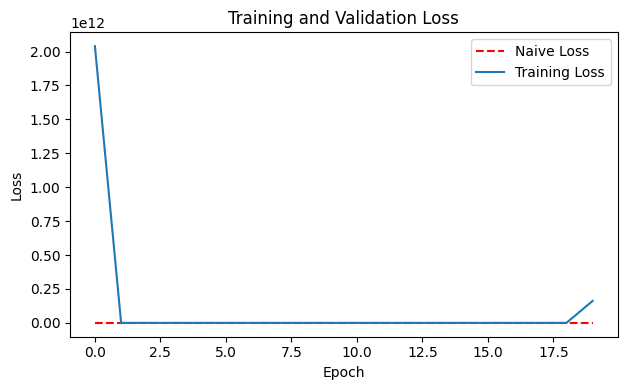

3/3 [==============================] - 0s 28ms/step - loss: 3302.0359 - mae: 44.2071


INFO:tensorflow:Assets written to: gs://vgnn/models/32_buckets_9-jovial-caramel-20241029-022019.tf/assets


INFO:tensorflow:Assets written to: gs://vgnn/models/32_buckets_9-jovial-caramel-20241029-022019.tf/assets


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch/mae,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃
epoch/val_loss,▂▁▁▁▁▁█▁▁▂▁▁▁▁▁▁▄▁▁▁
epoch/val_mae,▃▂▂▃▂▁█▂▁▃▂▁▂▁▂▂▃▁▁▁
epoch/epoch,19
epoch/learning_rate,0.09975
epoch/loss,162079440896.0
epoch/mae,70322.95312
epoch/val_loss,2906.77808


wandb: Agent Starting Run: tzhb9u8b with config:
wandb: 	batch_size: 64
wandb: 	dense_layers_per_step: 17
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	kernel_initializer: 0
wandb: 	lr: 0.04730764703095722
wandb: 	lstm_layers_units: [3, 5]
wandb: 	num_bins_num_bands: [12, 3]
wandb: 	optimizer: nadam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Dataset shape: (815, 3, 36)
Input_shpae: (3, 36)
Train size: 10 
Validation size: 1
Data sets have been setup
Model has been defined
Model compiled
Epoch 1/20
9/9 [==============================] - 3s 262ms/step - loss: 20930.1152 - mae: 136.7566 - val_loss: 19453.8125 - val_mae: 131.2588
Epoch 2/20
9/9 [==============================] - 2s 243ms/step - loss: 19690.5332 - mae: 132.7868 - val_loss: 23959.5195 - val_mae: 153.3946
Epoch 3/20
9/9 [==============================] - 2s 246ms/step - loss: 19096.3359 - mae: 130.7818 - val_loss: 14809.4961 - val_mae: 111.1245
Epoch 4/20
9/9 [==============================] - 2s 247ms/step - loss: 18734.9902 - mae: 129.9335 - val_loss: 16776.4531 - val_mae: 122.6691
Epoch 5/20
9/9 [==============================] - 2s 245ms/step - loss: 10413.4492 - mae: 96.0294 - val_loss: 8917.7812 - val_mae: 89.6621


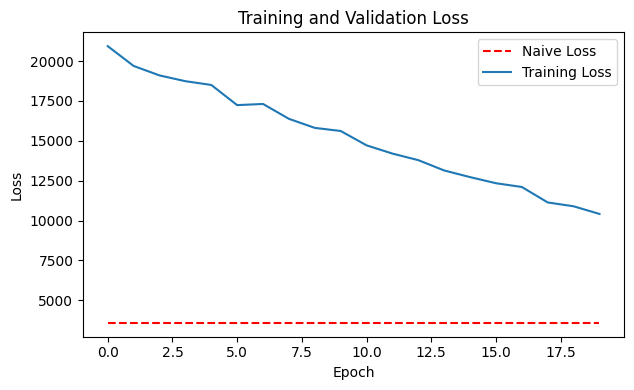

1/1 [==============================] - 0s 70ms/step - loss: 8917.7812 - mae: 89.6621


INFO:tensorflow:Assets written to: gs://vgnn/models/32_buckets_9-sunny-tartar-20241029-022110.tf/assets


INFO:tensorflow:Assets written to: gs://vgnn/models/32_buckets_9-sunny-tartar-20241029-022110.tf/assets


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁▁
epoch/mae,█▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
epoch/val_loss,▆█▄▅▄▆▅▄▆▄▃▃▃▃▂▂▂▃▃▁
epoch/val_mae,▆█▃▅▄▆▄▄▆▅▃▃▃▃▂▂▂▃▄▁
epoch/epoch,19
epoch/learning_rate,0.04731
epoch/loss,10413.44922
epoch/mae,96.02941
epoch/val_loss,8917.78125


wandb: Agent Starting Run: d2nrb3ce with config:
wandb: 	batch_size: 32
wandb: 	dense_layers_per_step: 27
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 15
wandb: 	kernel_initializer: 0
wandb: 	lr: 0.0808749609603208
wandb: 	lstm_layers_units: [10, 25]
wandb: 	num_bins_num_bands: [12, 9]
wandb: 	optimizer: rms
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Dataset shape: (815, 3, 108)
Input_shpae: (3, 108)
Train size: 20 
Validation size: 3
Data sets have been setup
Model has been defined
Model compiled
Epoch 1/15
17/17 [==============================] - 7s 418ms/step - loss: 13032.4756 - mae: 106.0348 - val_loss: 8383.4619 - val_mae: 83.7569
Epoch 2/15
17/17 [==============================] - 7s 422ms/step - loss: 6041.2437 - mae: 69.2481 - val_loss: 4148.7456 - val_mae: 53.9155
Epoch 3/15
17/17 [==============================] - 7s 406ms/step - loss: 3759.6582 - mae: 49.0795 - val_loss: 3145.6824 - val_mae: 45.5065
Epoch 4/15
17/17 [==============================] - 7s 413ms/step - loss: 3496.1526 - mae: 41.5496 - val_loss: 3747.8623 - val_mae: 44.4643
Epoch 5/15
17/17 [==============================] - 7s 403ms/step - loss: 3482.7483 - mae: 41.0991 - val_loss: 3275.4053 - val_mae: 42.7148
Epoch 6/15
17/17 [==============================] - 7s 412ms/step - loss: 3707.3096 - mae: 42.6616 - val_loss: 4220.4048 - val_mae: 46.7897
Epoch 7/

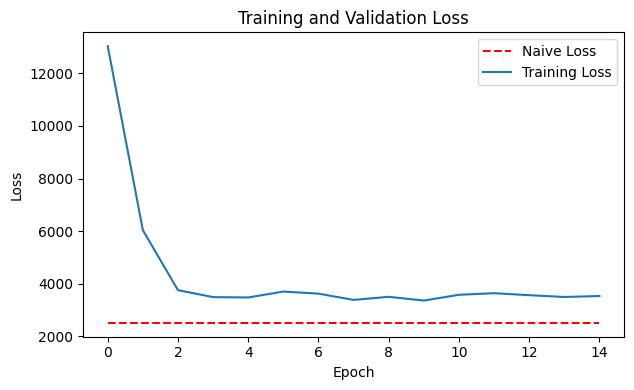

3/3 [==============================] - 0s 144ms/step - loss: 3679.9082 - mae: 46.0375


In [ ]:

# Define the initializers you want to test
initializers = [
    tf.keras.initializers.RandomNormal(seed=42),
    tf.keras.initializers.RandomUniform(seed=42),
    tf.keras.initializers.HeNormal(seed=42),
    tf.keras.initializers.GlorotUniform(seed=42)
]

sweep_configuration = {
    "name": "bm_sweep",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "lstm_layers_units": {"values": [(0,0), (3,5), (10,25)]},
        "dense_layers_per_step": {"values": [10, 17, 27]},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "kernel_initializer": {"values": [0,1,2,3]},
        "num_bins_num_bands": {"values": [(12, 3), (12,9), (32,9), (60,3), (60,9)]},
        "lr": {"min": 0.0001, "max": 0.1},
        "batch_size": {"values": [16, 32, 64]},
        "epochs": {"values": [10, 15,20]},
        "optimizer": {"values": ["adam", "rms", "nadam"]},
    },
}


def train():
    try:
        wandb.init()

        map_nan = True
        normalize = True
        # Get dataset for testing
        num_bins, num_bands = wandb.config.num_bins_num_bands
        directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}"
        dataset, dataset_shape = load_dataset_from_gcp(directory=directory)
        input_shape = dataset_shape[1:]

        print(f"Dataset shape: {dataset_shape}", f"Input_shpae: {input_shape}", sep="\n")

        # Train test split
        test_train_split = 0.8
        train_size = int(dataset_shape[0] * test_train_split / wandb.config.batch_size)
        val_size = int(train_size * (1-test_train_split))

        dataset_batched = dataset.batch(wandb.config.batch_size, drop_remainder=True)
        test_dataset = dataset_batched.skip(train_size)
        train_dataset = dataset_batched.take(train_size)

        train_dataset = train_dataset.shuffle(buffer_size=10000)
        print(f"Train size: {train_size} \nValidation size: {val_size}")
        print("Data sets have been setup")
        
        lstm_layers, lstm_units = wandb.config.lstm_layers_units

        model = TimeDependentDenseLstmModel(input_shape = input_shape,
                                        lstm_layers = lstm_layers,
                                        dense_layers_per_step = wandb.config.dense_layers_per_step,
                                        no_units = lstm_units,
                                        val_size = val_size,
                                        dropout_rate = wandb.config.dropout_rate,
                                        kernel_initializer = initializers[wandb.config.kernel_initializer])
        print("Model has been defined")

        model.compile(optimizer= wandb.config.optimizer,
                      learning_rate = wandb.config.lr,
                      loss=pen_low_lenient_high_loss)

        print("Model compiled")

        history = model.fit(train_dataset, epochs=wandb.config.epochs)

    except ValueError as e:
        print(f"Value error in configuration or dataset: {e}")
    except tf.errors.InvalidArgumentError as e:
        print(f"TensorFlow-specific error: {e}")
    except Exception as e:
        print(f"Unexpected error occurred: {e}")    
    except Exception as e:
        print(f"An error occurred: {e}")
        wandb.alert(title="Training Error", text=str(e))
    finally:
        wandb.finish()                

sweep_id = wandb.sweep(sweep_configuration,
                      project="blue-marble")
wandb.agent(sweep_id, function=train)



In [14]:
wandb.finish() 

In [20]:
model.evaluate(test_dataset)

8/8 [==============================] - 1s 87ms/step - loss: 2203.0098 - mae: 34.5621


[2203.009765625, 34.56208419799805]

In [ ]:
model = LstmModel(input_shape=input_shape, lstm_layers=4, no_units=2, val_size=1)
model.compile(optimizer='nadam', learning_rate = 0.5)
history = model.fit(train_dataset, epochs=25)

In [22]:
print(model.job_name)

tf.Tensor(4171.9155, shape=(), dtype=float32)
lively-foie-gras


In [ ]:
for layer in model.layers:
    # Get weights for the layer
    weights = layer.get_weights()
    
    # Check if the layer has weights
    if weights:
        print(f"Layer: {layer.name}")
        for i, weight in enumerate(weights):
            print(f"  Weight {i+1} shape: {weight.shape}")
            print(f"  Weight {i+1} values: \n{weight}\n")
    else:
        print(f"Layer: {layer.name} has no weights.")

In [28]:
predictions = model.predict(test_dataset)

8/8 [==============================] - 1s 75ms/step


In [29]:
predictions[:10]

array([[119.643425],
       [119.643425],
       [119.643425],
       [119.643425],
       [119.643425],
       [119.643425],
       [119.643425],
       [119.643425],
       [119.643425],
       [119.643425]], dtype=float32)

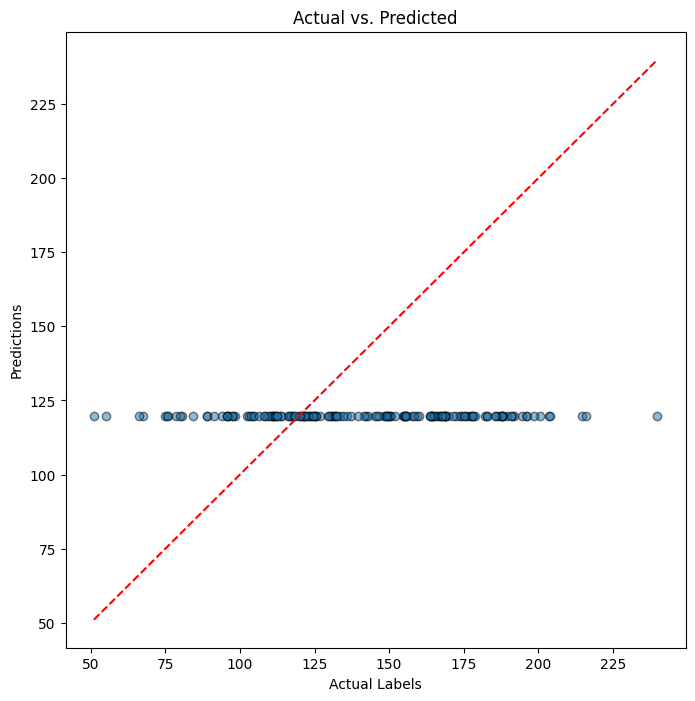

In [30]:
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, pred_mean, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [ ]:
for layer in model.layers:
    print(layer.weights)

In [16]:
model.summary()

Model: "time_dependent_dense_lstm_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               multiple                  5520      
                                                                 
 lstm_3 (LSTM)               multiple                  220       
                                                                 
 dense_11 (Dense)            multiple                  6         
                                                                 
 time_distributed_10 (TimeDi  multiple                 146070    
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  multiple                 73170     
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  mul

In [9]:
!ps aux | grep tensorboard

jupyter     9299  0.0  0.0   5704  3188 pts/0    Ss+  06:01   0:00 /bin/bash -c ps aux | grep tensorboard
jupyter     9301  0.0  0.0   5264  2236 pts/0    S+   06:01   0:00 grep tensorboard


In [8]:
!kill -9 9168

/bin/bash: line 1: kill: (9168) - No such process
